In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style

%matplotlib inline

In [ ]:

# function to filter noises and detect crack
def segmentCrack (img,minSize,imgTitle,detectCrack=True):
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1]
    img2 = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if sizes[i] >= minSize :
            img2[labels == i + 1] = 255

    res = cv2.bitwise_not(img2)


    ret, labels = cv2.connectedComponents(res)



    if (detectCrack==True):
        if (len(np.unique(labels))-1)>=1 :
            s = 'Crack detected'
            boxColor = 'red'
        else :
            s = "Good wall condition"
            boxColor = 'green'

        output= plt.imshow(res,cmap='gray'),plt.axis('off'),plt.text(50, 50, s,fontsize=15,color='yellow', bbox=dict(facecolor=boxColor,alpha=0.5)),plt.title(imgTitle)
    else :
        output=plt.imshow(res,cmap='gray'),plt.axis('off'),plt.title(imgTitle)

    return res # return the segmented image

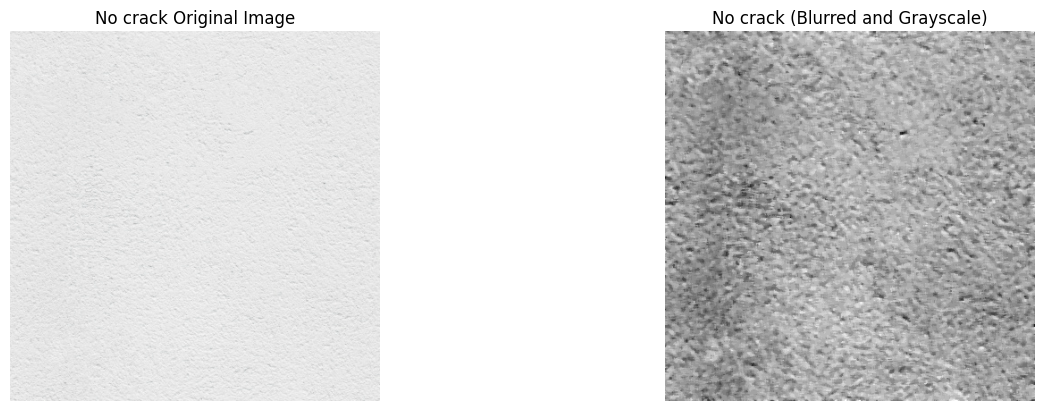

In [ ]:
no_crack = cv2.imread('nocrack .jpg')

no_crack_blur = cv2.medianBlur(no_crack,5)

no_crack_gray = cv2.cvtColor(no_crack_blur,cv2.COLOR_BGR2GRAY)

plt.subplot(1,2,1)
plt.imshow(no_crack,cmap='gray'), plt.axis('off'),plt.title("No crack Original Image")
plt.subplot(1,2,2)
plt.imshow(no_crack_gray,cmap='gray'), plt.axis('off'),plt.title("No crack (Blurred and Grayscale)")
plt.subplots_adjust(right=2)

(<matplotlib.image.AxesImage at 0x7e2f85c35210>,
 (-0.5, 413.5, 413.5, -0.5),
 Text(0.5, 1.0, 'No crack (after adaptive thresholding)'))

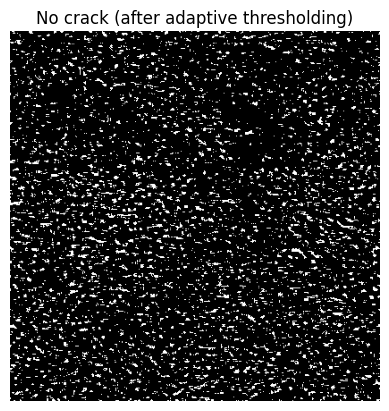

In [ ]:
no_crack_threshold = cv2.adaptiveThreshold(no_crack_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
plt.imshow(no_crack_threshold,cmap='gray'),plt.axis('off'),plt.title("No crack (after adaptive thresholding)")

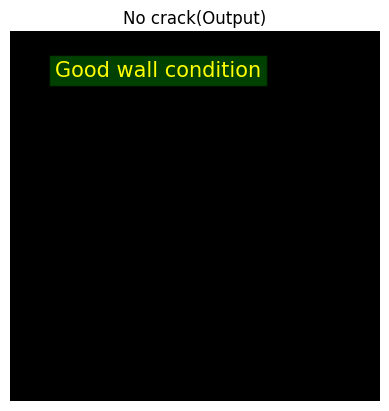

In [ ]:
output_no_crack=segmentCrack(no_crack_threshold,1200,"No crack(Output)")

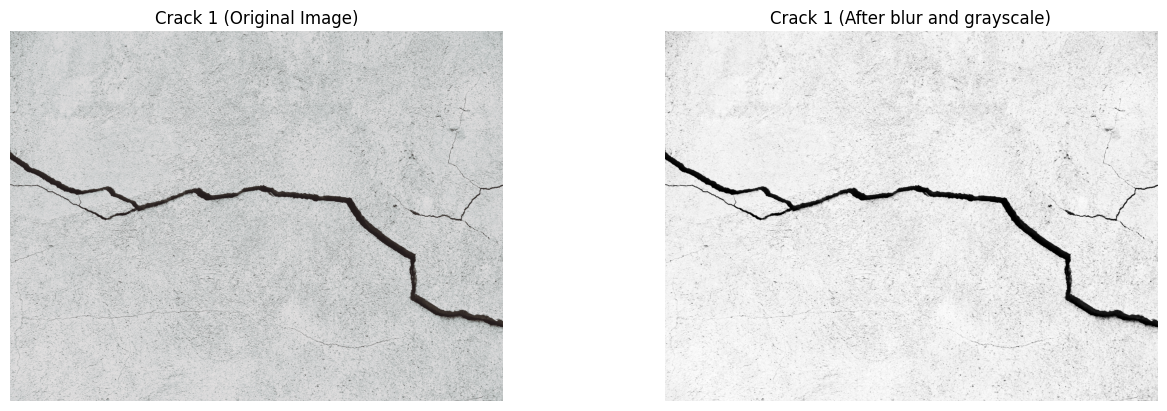

In [ ]:
crack_1 = cv2.imread('crack.jpg')

crack_1_blur = cv2.medianBlur(crack_1,5)
crack_1_gray = cv2.cvtColor(crack_1_blur,cv2.COLOR_BGR2GRAY)

plt.subplot(1,2,1)
plt.imshow(crack_1,cmap='gray'),plt.axis('off'),plt.title('Crack 1 (Original Image)')
plt.subplot(1,2,2)
plt.imshow(crack_1_gray,cmap='gray'),plt.axis('off'),plt.title("Crack 1 (After blur and grayscale)")
plt.subplots_adjust(right=2)

(<matplotlib.image.AxesImage at 0x7e2f878f9690>,
 (-0.5, 3647.5, 2735.5, -0.5),
 Text(0.5, 1.0, 'Crack 1 after thresholding'))

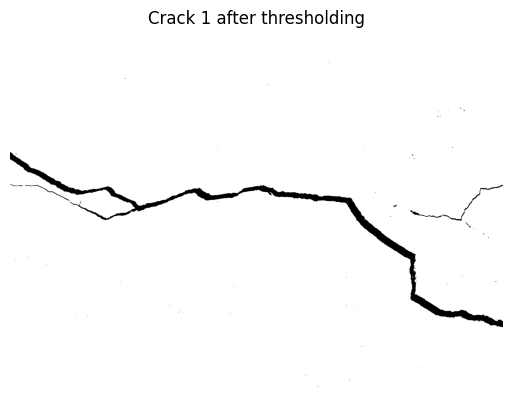

In [ ]:
ret,crack_1_threshold = cv2.threshold(crack_1_gray,70,255,cv2.THRESH_BINARY)
plt.imshow(crack_1_threshold,cmap='gray'),plt.axis('off'),plt.title("Crack 1 after thresholding")

(<matplotlib.image.AxesImage at 0x7e2f6a37c760>,
 (-0.5, 3647.5, 2735.5, -0.5),
 Text(0.5, 1.0, 'Crack 1 after thresholding with OTSU'))

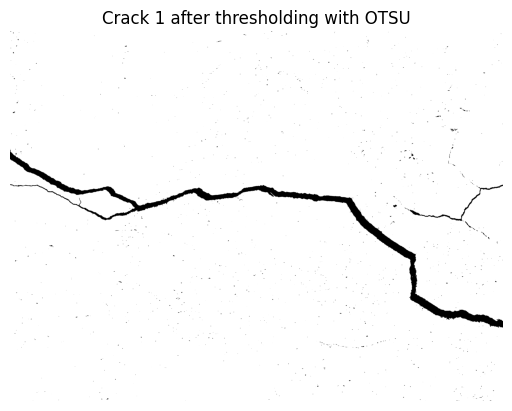

In [ ]:
res,crack_1_otsu = cv2.threshold(crack_1_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(crack_1_otsu,cmap='gray'),plt.axis('off'),plt.title("Crack 1 after thresholding with OTSU")

(<matplotlib.image.AxesImage at 0x7e2f6a15fdc0>,
 (-0.5, 3647.5, 2735.5, -0.5),
 Text(0.5, 1.0, 'Crack 1 (Canny edge)'))

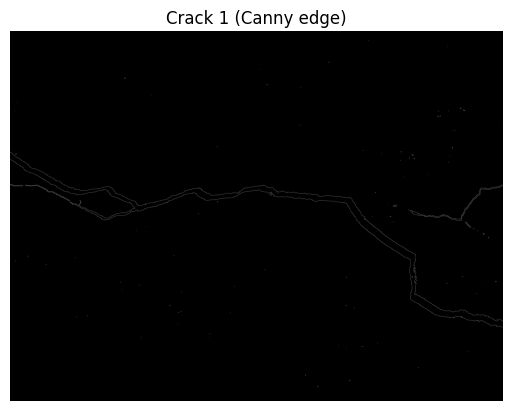

In [ ]:
crack_1_edge = cv2.Canny(crack_1_threshold,10,20)
plt.imshow(crack_1_edge, cmap='gray'), plt.axis('off'),plt.title("Crack 1 (Canny edge)")

(<matplotlib.image.AxesImage at 0x7e2f6a2b3070>,
 (-0.5, 3647.5, 2735.5, -0.5),
 Text(0.5, 1.0, 'Crack 1 (Closing)'))

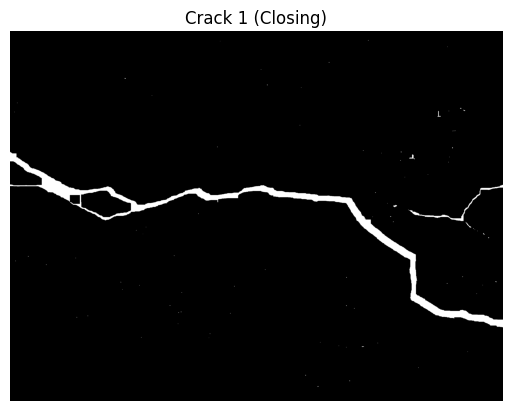

In [ ]:
se= cv2.getStructuringElement(cv2.MORPH_RECT,(50,50))
crack_1_closing = cv2.morphologyEx(crack_1_edge, cv2.MORPH_CLOSE, se)
plt.imshow(crack_1_closing,cmap='gray'), plt.axis('off'), plt.title('Crack 1 (Closing)')

(<matplotlib.image.AxesImage at 0x7e2f6bc3c5e0>,
 (-0.5, 3647.5, 2735.5, -0.5),
 Text(0.5, 1.0, 'Crack 1 (Opening)'))

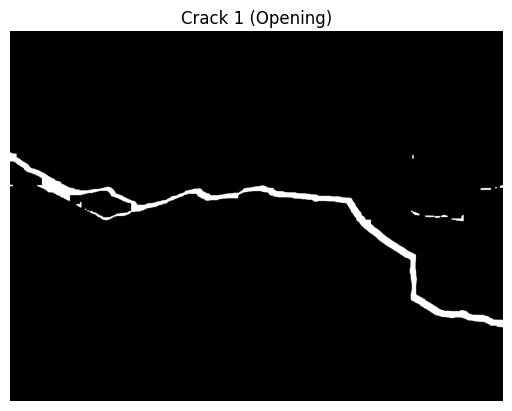

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))
crack_1_opening = cv2.morphologyEx(crack_1_closing, cv2.MORPH_OPEN, kernel)
plt.imshow(crack_1_opening,cmap='gray'), plt.axis('off'),plt.title('Crack 1 (Opening)')

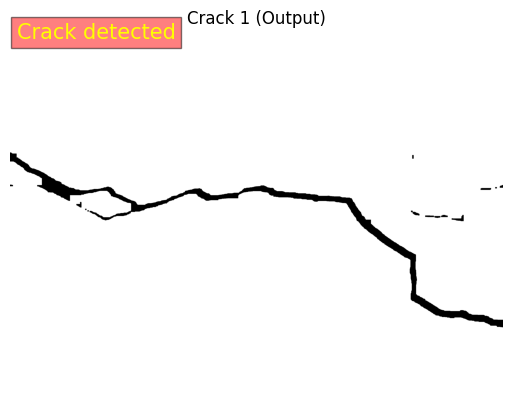

In [ ]:
output_crack_1 = segmentCrack(crack_1_opening,0,"Crack 1 (Output)")

In [ ]:
crack_1 = cv2.imread('crack.jpg')

Estimation of crack length and width

In [ ]:
""" Scaling factor in test image used is 883,642 nm/Px """
from skimage.morphology import medial_axis
from skimage.filters import threshold_otsu, gaussian
import numpy as np
import tifffile as tiff
from PIL import Image
#-----------------------------------------------------------------------------

im = Image.open('crack.jpg')
#DPI info
dpi = im.info.get('dpi', (72, 72))  # Defaults to 72 DPI if not set
print(f"DPI: {dpi}")
#-----------------------------------------------------------------------------

im.save("/content/crack1.tiff", 'TIFF')

img_name = "crack1"
img_type = ".tiff"
img = tiff.imread(img_name+img_type)
img = np.array(img.astype(int))
img = img.mean(axis=2)
gaussian_img = gaussian(img, sigma=7)
thresh = threshold_otsu(gaussian_img)
binary = np.array(gaussian_img > thresh, dtype=int)
image0 = binary
img_skeletonized, distance = medial_axis(image0, return_distance=True)
img_skeletonized = np.array(img_skeletonized.astype(int))
dist_on_skel = distance * img_skeletonized
width = dist_on_skel[dist_on_skel !=0]*2
for i in range(len(width)):
    if width[i] <= 2.0:
        width[i] = width[i]
    else:
        width[i] = width[i]-2
tiff.imsave(img_name+"_blurred-skeletonized"+img_type, img_skeletonized, shape=None, dtype=int)

#OUTPUT
length = np.count_nonzero(img_skeletonized)
mean_width = np.mean(width)
max_width = np.max(width)
min_width = np.min(width)
print("Summarized Cracklength = "+str(length)+" Px")
print("Mean crack width = "+str(mean_width)+" Px")
print("Max crack width = "+str(max_width)+" Px")
print("Min crack width = "+str(min_width)+" Px")
#-----------------------------------------------------------------------------
#CONVERT TO MM
LengthMM = length/dpi[0]
WidthMM = mean_width/dpi[1]
MaxMM = max_width/dpi[1]
MinMM = min_width/dpi[1]
print(f"Width (mm): {WidthMM}")
print(f"Max Width (mm): {MaxMM}")
print(f"Min Width (mm): {MinMM}")
print(f"Lengt (mm): {LengthMM}")

DPI: (300, 300)
Summarized Cracklength = 17910 Px
Mean crack width = 1306.6615526782928 Px
Max crack width = 3010.43555947675 Px
Min crack width = 2.0 Px
Width (mm): 4.355538508927642
Max Width (mm): 10.034785198255832
Min Width (mm): 0.006666666666666667
Lengt (mm): 59.7


<ipython-input-45-bd5a55fbf714>:43: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(img_name+"_blurred-skeletonized"+img_type, img_skeletonized, shape=None, dtype=int)


Airflow Calculation

,Air temperature C,Time
174576,-3.3,2023-12-01 00:00:00
174577,-3.6,2023-12-01 01:00:00
174578,-3.7,2023-12-01 02:00:00
174579,-3.8,2023-12-01 03:00:00
174580,-3.8,2023-12-01 04:00:00
...,...,...
175315,-6.1,2023-12-31 01:00:00
175316,-6.9,2023-12-31 02:00:00
175317,-7.6,2023-12-31 02:00:00
175318,-8.2,2023-12-31 02:00:00


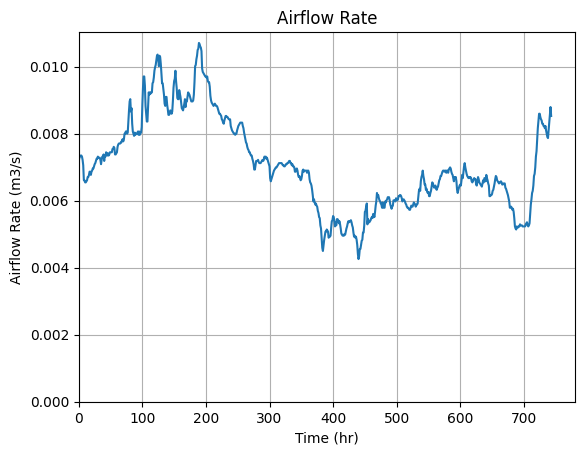

[0.00718891 0.00728577 0.0073181  0.00735046 0.00735046 0.0073181
 0.00722117 0.0070601  0.00661227 0.00661227 0.00654867 0.00654867
 0.00658046 0.00661227 0.00670784 0.00670784 0.00677168 0.00686761
 0.00686761 0.00677168 0.00686761 0.00689963 0.00696375 0.00696375
 0.00702796 0.00709227 0.00712446 0.00718891 0.00725346 0.00725346
 0.0073181  0.00728577 0.00728577 0.00728577 0.00722117 0.00709227
 0.00722117 0.0073181  0.0073181  0.00738284 0.00718891 0.00735046
 0.0073181  0.00744767 0.00741524 0.00735046 0.00741524 0.00735046
 0.00738284 0.00744767 0.00744767 0.00744767 0.00744767 0.00754511
 0.00754511 0.00761018 0.00757763 0.00738284 0.00738284 0.00741524
 0.00744767 0.00761018 0.00767536 0.00770798 0.00770798 0.00770798
 0.00774063 0.00774063 0.007806   0.00783872 0.0077733  0.00783872
 0.00800269 0.00800269 0.00806845 0.00806845 0.00800269 0.00803556
 0.0083656  0.00869813 0.00896596 0.00903318 0.00866476 0.00876494
 0.00829939 0.00806845 0.00800269 0.00793703 0.00803556 0.00796

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

tin = 273+21 # Inside temp
g = 9.81
hh = 6.5 # Height of the crack from the ground level
Np = 4.5 # Neutral pressure plane
R = 287 # Ideal gas coefficient
P = 101325 # Outside Pressure
H = 0.35 # Depth of the wall
w = WidthMM * 0.001# Width of the crack
L = LengthMM * 0.001 # Length of the crack
#-------------------------------------------------------------------------------------------------------------------

class Crack():
  def __init__(self, tin, g, hh, Np, R, P, w, L, H):
    self.w = w
    self.L = L
    self.H = H
    self.tin = tin
    # self.tout = tout
    self.g = g
    self.hh = hh
    self.Np = Np
    self.R = R
    self.P = P
#-------------------------------------------------------------------------------------------------------------------

  def read_csv(self):

    self.df = pd.read_csv('TT.csv',encoding='unicode_escape')
    self.df['mi'].fillna(0, inplace=True)
    self.df['ss'].fillna(0, inplace=True)
    self.df['time hour'] = self.df['hour'].apply(lambda x: int(x[:1]))
    self.df1 = self.df.drop(columns=['hour'])
    cols = ['Year','Month','day','time hour','mi','ss']
    d = {'mi':'minute','ss':'second', 'time hour':'hour'}
    self.df1['Time'] = pd.to_datetime(self.df1[cols].rename(columns=d))
    self.df1.Time = pd.to_datetime(self.df1.Time)
    self.df2 = self.df1.drop(columns=['Year','Month','day','mi','ss', 'Irradiation W/m2', 'Barometric pressure at sea level hPa', 'Barometric pressure at station height hPa',
                                      'Hourly rainfall in mm', 'Relative humidity %', 'Minimum hourly air temperature C', 'Hourly rainfall in mm',
                                        'Relative humidity %', 'Minimum hourly air temperature C',
                                        'Maximum hourly air temperature C','10 minutes average wind direction', '10 minuti keskmine tuule kiirus m/s',
                                        '10 minutes average wind speed in m/s', 'time hour'])



    # selected_dates = ['2023-12-15']
    # self.df2_new = self.df2[self.df2.Time.dt.strftime('%Y-%m-%d').isin(selected_dates)]
    selected_dates = ['2023-12']
    self.df2_new = self.df2[self.df2.Time.dt.strftime('%Y-%m').isin(selected_dates)]
    display(self.df2_new)
    self.list_toutside = self.df2_new['Air temperature C'].to_list()
    self.tout = np.array(self.list_toutside) + 273
    return self.tout




# Pressure drop of stack effect
  def Delta_P(self):
    h = hh -Np
    roout = P/(self.tout*R)
    self.dp = roout*g*h *((tin- self.tout)/tin)
    return  self.dp


  # Viscosity of air
  def mu(self):
    self.mu = 1.81*math.pow(10, -5 )
    return self.mu

  #Airflow Rate (m3/s)
  def Q_Total(self):
    self.q = (w*3*L/12*self.mu)*(self.dp/H)
    return self.q

  def plot(self):
    plt.plot(self.q)
    plt.title("Airflow Rate")
    plt.xlabel("Time (hr)")
    plt.ylabel("Airflow Rate (m3/s)")
    plt.grid(True)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.show()

def main():

  Flowrate = Crack(tin, g, hh, Np, R, P, w, L, H)
  Temperature_outside = Flowrate.read_csv()
  Pressure_drop = Flowrate.Delta_P()
  Viscosity = Flowrate.mu()
  Airflow = Flowrate.Q_Total()
  Flowrate.plot()
  print(Airflow)



if __name__ == '__main__':
   main()
